# Feature Engineering I
In this module, we will practice the skills used in feature engineering. Variables are often not in a proper form prior to modeling with machine learning algorithms, and so we must be careful to properly apply feature engineering techniques to prepare our data before using our machine learning techniques.

We will again be working with our dataset from the students' performance dataset that was obtained from kaggle and hosted on the Thinkful SQL Database which we will access below. We are interseted in exploring the following questions:

1. Are the exam score variables normally distributed? If not, apply a Box-Cox transformation. Does anything change?
2. Say we want to use a single variable for the exam scores as our target. For this purpose, create a new variable by taking a weighted average of the exam scores. Check whether this new variable is normally distributed. If it's not normally distributed, apply a Box-Cox transformation and check whether or not the transformed variable is normally distributed.
3. Which variables seem related to the target variable (the newly created variable in the previous question)? If our goal is to explain the determinants of success in exams, which variables in our dataset might be useful?

#### Libraries and Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
import warnings
warnings.filterwarnings('ignore')

#### Import Dataset

In [6]:
sql_query = '''
SELECT * FROM studentsperformance
'''

In [199]:
from sqlalchemy import create_engine

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'studentsperformance'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

student_df = pd.read_sql_query(sql_query, con=engine)

In [9]:
engine.dispose()

## Exploratory Data Analysis (EDA)

In [10]:
student_df.sample(5)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
300,male,group A,some college,free/reduced,completed,81,78,81
849,male,group D,associate's degree,standard,none,80,75,69
472,female,group C,associate's degree,standard,completed,68,86,84
702,male,group A,bachelor's degree,standard,completed,87,84,87
640,male,group D,high school,standard,none,41,52,51


In [11]:
student_df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [12]:
student_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
gender                         1000 non-null object
race/ethnicity                 1000 non-null object
parental level of education    1000 non-null object
lunch                          1000 non-null object
test preparation course        1000 non-null object
math score                     1000 non-null int64
reading score                  1000 non-null int64
writing score                  1000 non-null int64
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


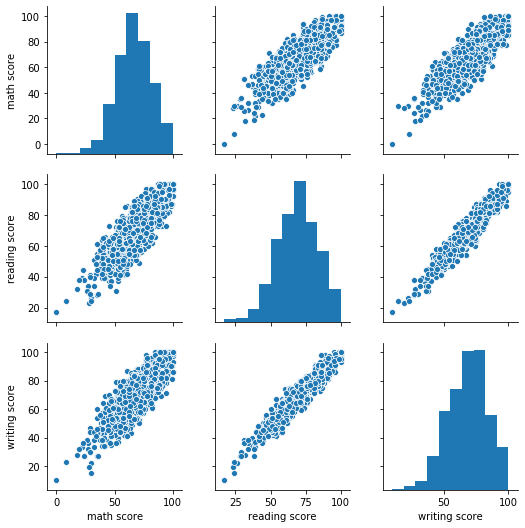

In [13]:
sns.pairplot(student_df)
plt.show()

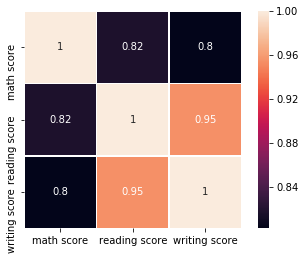

In [15]:
sns.heatmap(student_df.corr(), annot=True, square=True, linewidth=.5)
plt.show()

## 1. Checking for Normality in Exam Scores; Applying Box-Cox Transformation
Let us check to see if the exam score variables are normally distributed or not. This is a critical part of our feature engineering as many machine learning models assume that our features are normally distributed.

In [26]:
math_df = student_df[student_df['math score']>0]['math score']
reading_df = student_df[student_df['reading score']>0]['reading score']
writing_df = student_df[student_df['writing score']>0]['writing score']

In [35]:
score_cols = ['math score', 'reading score', 'writing score']

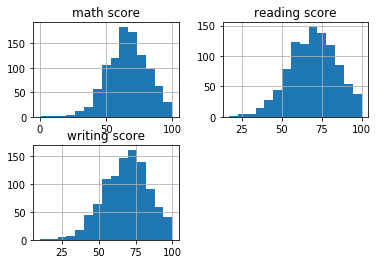

In [40]:
student_df[score_cols].hist(bins=15)
plt.show()

We can see that the scores are skewed left. We will need to apply some kind of transformation on it in order to fix our data. We will use scipy's box-cox transformation.

In [59]:
from scipy.stats import boxcox

math_df_boxcox, _ = boxcox(math_df)
reading_df_boxcox, _ = boxcox(reading_df)
writing_df_boxcox, _ = boxcox(writing_df)

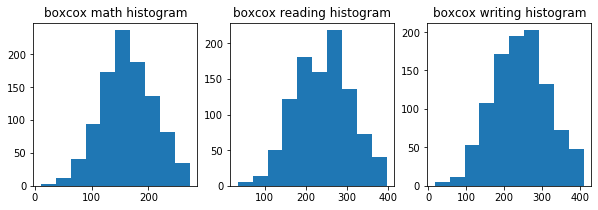

In [79]:
plt.figure(figsize=(10,3))

plt.subplot(1,3,1)
plt.hist(math_df_boxcox)
plt.title('boxcox math histogram')

plt.subplot(1,3,2)
plt.hist(reading_df_boxcox)
plt.title('boxcox reading histogram')

plt.subplot(1,3,3)
plt.hist(writing_df_boxcox)
plt.title('boxcox writing histogram')

plt.show()

Let us confirm that these are closer to being normally distributed with a 5% significance level Jarque-bera test and normality test:

In [119]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

boxcox_group = [math_df_boxcox, reading_df_boxcox, writing_df_boxcox]
sig_level = 0.05

for group in boxcox_group:    
    jb_stats = jarque_bera(group)
    norm_stats = normaltest(group)
        
    if jb_stats[1] < sig_level*0.01:
        jb_sig_mark = '***'
    elif jb_stats[1] < sig_level*0.1:
        jb_sig_mark = '**'
    elif jb_stats[1] < sig_level:
        jb_sig_mark = '*'
    else:
        jb_sig_mark = ''
            
    if norm_stats[1] < sig_level*0.01:
        norm_sig_mark = '***'
    elif norm_stats[1] < sig_level*0.1:
        norm_sig_mark = '**'
    elif norm_stats[1] < sig_level:
        norm_sig_mark = '*'
    else:
        norm_sig_mark = ''
            
    print(f'Jarque-Bera Test Statistic = {jb_stats[0]:2.3f}, p-value = {jb_stats[1]:2.3f} {jb_sig_mark}')
    print(f'Normality Test Statistic = {norm_stats[0]:2.3f}, p-value = {norm_stats[1]:2.3f} {norm_sig_mark}')

Jarque-Bera Test Statistic = 1.720, p-value = 0.423 
Normality Test Statistic = 1.832, p-value = 0.400 
Jarque-Bera Test Statistic = 4.120, p-value = 0.127 
Normality Test Statistic = 5.282, p-value = 0.071 
Jarque-Bera Test Statistic = 4.746, p-value = 0.093 
Normality Test Statistic = 6.267, p-value = 0.044 *


The hypothesis for the Jarque-Bera Test and the Normality test is that it comes from a normal distribution. Hence, we can say that at least to some degree we have been able to transform the data into something of a normal distribution.

## 3. New Variable of Weighted Average - Check for Normal Distribution
We will suppose we have a new variable of weighted averages of the exam scores, and we will check if it is normally distributed or not.

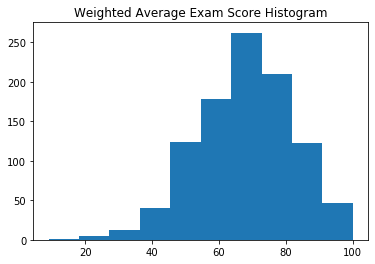

In [123]:
exam_score = (student_df['math score'] + student_df['reading score'] + student_df['writing score']) / 3

plt.hist(exam_score)
plt.title('Weighted Average Exam Score Histogram')
plt.show()

Visually, we don't see what looks like a normal distribution. We confirm this with the Jarque-Bera Test and the Normality Test.

In [125]:
jb_stats = jarque_bera(exam_score)
norm_stats = normaltest(exam_score)

print(f'Jarque-Bera Test Statistic = {jb_stats[0]}, p-value = {jb_stats[1]}')
print(f'Normality Test Statistic = {norm_stats[0]}, p-value = {norm_stats[1]}')

Jarque-Bera Test Statistic = 15.453387913085168, p-value = 0.00044089934264401887
Normality Test Statistic = 15.186721327231322, p-value = 0.0005037851534494478


The results are highly significant; this means we reject the null that the new variable is from a normal distribution.

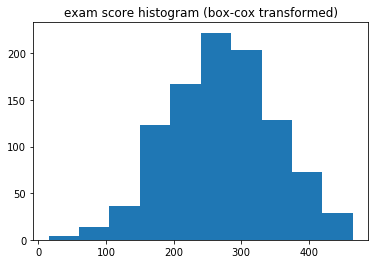

In [127]:
exam_boxcox, _ = boxcox(exam_score)

plt.hist(exam_boxcox)
plt.title('exam score histogram (box-cox transformed)')
plt.show()

In [130]:
jb_stats = jarque_bera(exam_boxcox)
norm_stats = normaltest(exam_boxcox)

print(f'Jarque-Bera Test Statistic = {jb_stats[0]}, p-value = {jb_stats[1]}')
print(f'Normality Test Statistic = {norm_stats[0]}, p-value = {norm_stats[1]}')

Jarque-Bera Test Statistic = 2.4353989331279173, p-value = 0.29591013563984203
Normality Test Statistic = 2.779857602227616, p-value = 0.24909303914726724


Now our transformed variable is normally distributed.

## Most Deterministic Features for Scores

In [145]:
student_df.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score', 'exam_score'],
      dtype='object')

In [158]:
student_df_cat = student_df.select_dtypes(include=['object'])

In [181]:
encoded_df = pd.get_dummies(student_df_cat, drop_first=True)

In [201]:
student_df.drop(list(student_df_cat.columns.values), axis=1, inplace=True)

In [206]:
student_df['average score'] = (student_df['math score'] + student_df['reading score'] + student_df['writing score']) / 3
student_df.drop(columns=['math score', 'reading score', 'writing score'], axis=1, inplace=True)

In [208]:
final_df = student_df.join(encoded_df)